In [1]:
import json
import os
import random
import re
from itertools import product

import numpy as np
import pandas as pd
from more_itertools import distinct_combinations
from plotnine import *
from sklearn import feature_extraction, metrics


ROOT_PATH = os.path.dirname(os.path.abspath(os.getcwd()))

In [2]:
def inspect_df(df: pd.DataFrame, n : int=5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""
    
    print(f'shape: {df.shape}')

    return df.head(n)

# Table of Contents
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [A Baseline Model: random classifier](#A-Baseline-Model:-random-classifier)
- [A Better Baseline Model: \<page title\> similarity](#A-Better-Baseline-Model:-<page-title>-similarity)
- [Feature Extraction](#Feature-Extraction)

# Exploratory Data Analysis

In [3]:
def json_loader(dirpath: str) -> list:
    """Discover all .json files and gather their respective data, given a `dirpath`.
    """
    data = []
    for subdir in os.listdir(dirpath):
        
        temp = os.path.join(dirpath, subdir)

        for datafile in os.listdir(temp):

            with open(os.path.join(temp, datafile), 'r') as f:

                spec = json.loads(f.read())
            
            # keep global identifier, format it as in the labelled dataset
            spec['id'] = subdir + '//' + datafile.split('.json')[0]
            
            data.append(spec)

    return data

In [4]:
data = json_loader(dirpath=os.path.join(ROOT_PATH, 'data/2013_camera_specs'))

In [5]:
specs = pd.DataFrame(data)

In [6]:
inspect_df(specs)

shape: (29787, 4662)


,<page title>,camera type,depth,digital zoom,effective megapixels,flash,focal length,height,image sensor,image stabilization,...,motion image progressive pal area,focus mode manual focus,my camera,sound files,af system points,ultrasonic motor usm,remote controller switch,image erase,image erase protection,gps log
0,Canon PowerShot SX200 IS 12.1 Megapixel Compac...,Compact Camera,1.5 in,4x,12.1 Megapixel,Auto Flash|Flash OFF|Flash ON|Red-eye Reduction,5 mm to 60 mm,2.4 in,CCD,Optical,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sony DSC-RX100/B Black Digital Camera (20.2 MP...,Point & Shoot Digital Camera,1.44 in,14 X,20200000 pixels,Built-in Flash|Accessory Shoe,NaN,2.38 in,CMOS,Optical,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Canon EOS-1D X Black SLR Digital Camera - Body...,Digital SLR Camera,3.3 in,NaN,18.1 Megapixel,Auto Flash|Flash ON|Flash OFF|X-sync|Rear Curt...,NaN,6.4 in,CMOS,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Olympus Pen E-P5 White Digital Camera (16.1 MP...,Point & Shoot Digital Camera,1.46 in,NaN,16100000 pixels,Built-in Flash|Accessory Shoe,NaN,2.71 in,CMOS,Sensor Shift,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Canon PowerShot G1 X Mark II Black Digital Cam...,Point & Shoot Digital Camera,2.61 in,4 X,12800000 pixels,Accessory Shoe|Built-in Flash,12.5 mm to 62.5 mm,2.91 in,CMOS,Optical,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
specs.set_index('id', inplace=True)

In [8]:
labels = pd.read_csv(os.path.join(ROOT_PATH, 'data/sigmod_medium_labelled_dataset.csv'))

In [9]:
inspect_df(labels)

shape: (46665, 3)


,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [10]:
matched_products = labels['label'] == 1

In [11]:
matched_products.value_counts()

False    43083
True      3582
Name: label, dtype: int64

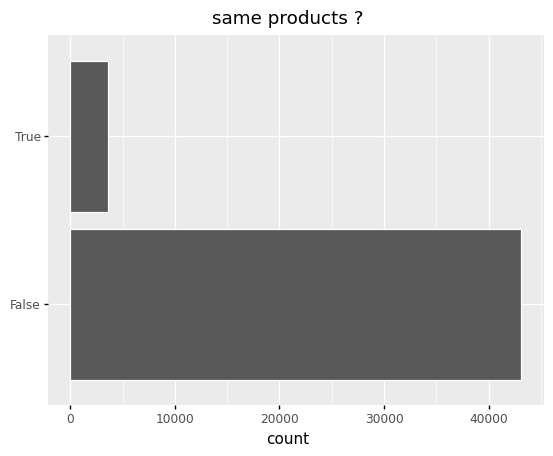

<ggplot: (8767409042285)>

In [12]:
ggplot() + \
    geom_bar(mapping=aes(x=matched_products), colour='white') + \
    labs(title='same products ?', x='') + \
    coord_flip()

In [13]:
specs_info = specs.describe()
specs_info = specs_info.transpose()

inspect_df(specs_info)

shape: (4661, 4)


,count,unique,top,freq
<page title>,29787,26748,Canon EOS Rebel T3i 600D 18 0 MP Digital SLR C...,26
camera type,2080,92,Point-and-Shoot,252
depth,1176,353,20 mm,28
digital zoom,3216,286,4x,1004
effective megapixels,344,91,16 Megapixel,40


In [14]:
specs_info['support'] = specs_info['count'] / len(specs.index)
specs_info = specs_info.sort_values(by='support', ascending=False)

In [15]:
specs_info.head(10)

,count,unique,top,freq,support
<page title>,29787,26748,Canon EOS Rebel T3i 600D 18 0 MP Digital SLR C...,26,1.0
brand,15739,348,Canon,3858,0.528385
model,14748,3993,7D,142,0.495115
megapixels,13827,477,16.0 MP,868,0.464196
type,13660,437,Point & Shoot,6638,0.458589
screen size,12350,365,"3""",5027,0.41461
optical zoom,11656,578,3x,2857,0.391312
mpn,10536,3452,5169B003,93,0.353711
condition,9951,13,Used: An item that has been used previously. T...,5730,0.334072
upc,7800,3723,013803117493,68,0.261859


In [16]:
top10 = list(specs_info.head(10).index)

These are the 10 camera specs (attributes) with the highest support.

In [17]:
specs[top10]

,<page title>,brand,model,megapixels,type,screen size,optical zoom,mpn,condition,upc
id,,,,,,,,,,
buy.net//6015,Canon PowerShot SX200 IS 12.1 Megapixel Compac...,NaN,NaN,NaN,NaN,NaN,12 X,NaN,NaN,NaN
buy.net//6383,Sony DSC-RX100/B Black Digital Camera (20.2 MP...,NaN,NaN,NaN,NaN,NaN,3.6 X,NaN,NaN,NaN
buy.net//6698,Canon EOS-1D X Black SLR Digital Camera - Body...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy.net//6123,Olympus Pen E-P5 White Digital Camera (16.1 MP...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy.net//6212,Canon PowerShot G1 X Mark II Black Digital Cam...,NaN,NaN,NaN,NaN,NaN,5 X,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
www.canon-europe.com//78,Canon PowerShot D30 - PowerShot and IXUS digit...,NaN,NaN,NaN,TTL,NaN,NaN,NaN,NaN,NaN
www.canon-europe.com//63,Canon PowerShot A550 - PowerShot and IXUS digi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
www.canon-europe.com//156,Canon Digital IXUS 900 Ti - PowerShot and IXUS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# A Baseline Model: random classifier

In [18]:
inspect_df(labels)

shape: (46665, 3)


,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [19]:
def random_classifier(*args):
    """A random classifier.
    
    Returns: True of False (i.e. if products are the same)
    """
    return random.random() > 0.5

In [20]:
predictions = labels.apply(random_classifier, axis=1)

In [21]:
metrics.accuracy_score(predictions, labels['label'])

0.49767491696132005

In [22]:
metrics.precision_score(predictions, labels['label'])

0.5022333891680625

In [23]:
metrics.recall_score(predictions, labels['label'])

0.07669352432109817

In [24]:
metrics.f1_score(predictions, labels['label'])

0.13306705129627575

This is a good indication of the model performance:  **f1 = 0.1337**

In [25]:
metrics.confusion_matrix(predictions, labels['label'])

array([[21425,  1783],
       [21658,  1799]])

This is the initial, baseline performance. Our model should easily outperform this random classifier.

# A Better Baseline Model: \<page title\> similarity

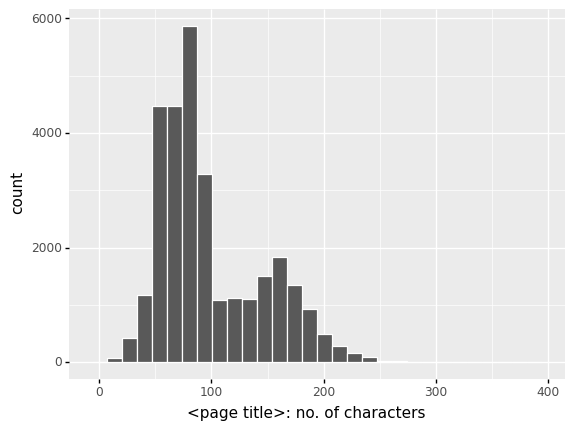

<ggplot: (8767331166313)>

In [26]:
ggplot() + \
    geom_histogram(mapping=aes(x=specs['<page title>'].map(len)), colour='white', bins=30) + \
    xlab('<page title>: no. of characters ')

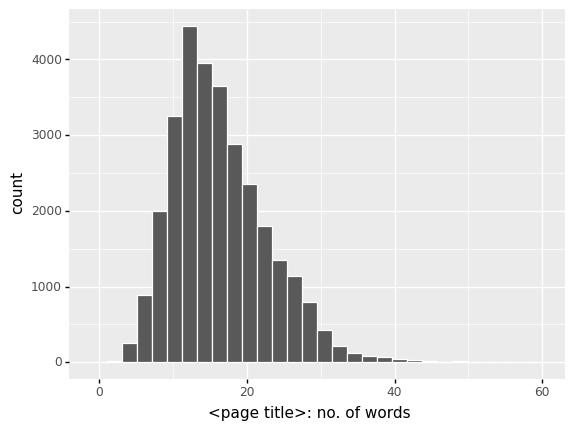

<ggplot: (8767331098953)>

In [27]:
ggplot() + \
    geom_histogram(mapping=aes(x=specs['<page title>'].map(lambda title: len(title.split()))), colour='white', bins=30) + \
    xlab('<page title>: no. of words')

We will use a BoW model + a text similarity algorithm + a suitable threshold in order to assert whether two cameras are the same.

In [28]:
def get_corpus(data: pd.DataFrame) -> np.ndarray:
    
    return data['<page title>'].values

In [29]:
vectorizer = feature_extraction.text.CountVectorizer()

In [30]:
vectorizer.fit(get_corpus(specs))

CountVectorizer()

In [31]:
def create_dataset(data: pd.DataFrame, labels: pd.DataFrame, features: list):
    """Helper method that creates a dataset.
    """
    left_part = pd.merge(labels, data[features], how='inner', left_on='left_spec_id', right_on='id')
    
    right_part = pd.merge(labels, data[features], how='inner', left_on='right_spec_id', right_on='id')
    
    dataset = pd.merge(left_part, right_part, how='inner', on=('left_spec_id', 'right_spec_id'), 
                       suffixes=('_left', '_right'))
    
    dataset['label'] = dataset['label_left']
    dataset.drop(['label_left', 'label_right'], axis=1, inplace=True)
    
    dataset.set_index(['left_spec_id', 'right_spec_id'], inplace=True)
    
    return dataset

In [32]:
X = create_dataset(data=specs, labels=labels, features=top10[0])

inspect_df(X)

shape: (46665, 3)


<page title>_left  \
left_spec_id            right_spec_id                                                    
www.garricks.com.au//31 www.ebay.com//53278       Nikon D3200 Black w/ 18-55mm VR Lens   
                        www.ebay.com//48947       Nikon D3200 Black w/ 18-55mm VR Lens   
                        www.ebay.com//42569       Nikon D3200 Black w/ 18-55mm VR Lens   
                        www.shopbot.com.au//1376  Nikon D3200 Black w/ 18-55mm VR Lens   
                        www.ebay.com//55623       Nikon D3200 Black w/ 18-55mm VR Lens   

                                                                                 <page title>_right  \
left_spec_id            right_spec_id                                                                 
www.garricks.com.au//31 www.ebay.com//53278       Nikon D3200 24 2 MP Digital SLR Camera Black K...   
                        www.ebay.com//48947       Canon EOS 5D 12 8MP Digital SLR with Battery G...   
                        www.ebay.com//42569       Nikon D800 36 3 MP MB D12 Multi Power Battery ...   
                        www.shopbot.com.au//1376  Nikon D7000 / 18-105mm VR Kit - Price comparis...   
                        www.ebay.com//55623       Nikon D7000 16 2 MP Digital SLR Camera Black K...   

                                                  label  
left_spec_id            right_spec_id                    
www.garricks.com.au//31 www.ebay.com//53278           1  
                        www.ebay.com//48947           0  
                        www.ebay.com//42569           0  
                        www.shopbot.com.au//1376      0  
                        www.ebay.com//55623           0

In [33]:
def pagetitle_similarity(title1: str, title2: str) -> float:
    
    vec1 = vectorizer.transform([title1])
    vec2 = vectorizer.transform([title2])

    return metrics.pairwise.cosine_similarity(vec1, vec2).take(0)

In [34]:
X['similarity'] = X[['<page title>_left', '<page title>_right']].apply(lambda x: pagetitle_similarity(x[0], x[1]), axis=1)

In [35]:
X[X['label'] == 1]['similarity'].mean()

0.44840187004232046

In [36]:
X[X['label'] == 0]['similarity'].mean()

0.21454835609656142

In [37]:
X['predictions'] = X['similarity'].map(lambda score: score > 0.5)

In [38]:
metrics.accuracy_score(X['predictions'], X['label'])

0.9056894889103182

In [39]:
metrics.precision_score(X['predictions'], X['label'])

0.38358458961474035

In [40]:
metrics.recall_score(X['predictions'], X['label'])

0.38519764507989906

In [41]:
metrics.f1_score(X['predictions'], X['label'])

0.38438942509441876

With this model we improved:  **f1 = 0.3843**

In [42]:
metrics.confusion_matrix(X['predictions'], X['label'])

array([[40890,  2208],
       [ 2193,  1374]])

We can definitely improve over this by a better choice of text embeddings or similarity algorithm.

But, all things considered, any approach that relies on the notion of similarity between page titles could not drastically improve the 0.38 F1 score.

It is time to proceed with an ML approach.

# Feature Extraction

In [43]:
MAX_PRODUCTS = 1000

In [44]:
camera_pairs = list(distinct_combinations(specs.index[:MAX_PRODUCTS], 2))

In [46]:
inspect_df(specs[top10])

shape: (29787, 10)


,<page title>,brand,model,megapixels,type,screen size,optical zoom,mpn,condition,upc
id,,,,,,,,,,
buy.net//6015,Canon PowerShot SX200 IS 12.1 Megapixel Compac...,NaN,NaN,NaN,NaN,NaN,12 X,NaN,NaN,NaN
buy.net//6383,Sony DSC-RX100/B Black Digital Camera (20.2 MP...,NaN,NaN,NaN,NaN,NaN,3.6 X,NaN,NaN,NaN
buy.net//6698,Canon EOS-1D X Black SLR Digital Camera - Body...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy.net//6123,Olympus Pen E-P5 White Digital Camera (16.1 MP...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy.net//6212,Canon PowerShot G1 X Mark II Black Digital Cam...,NaN,NaN,NaN,NaN,NaN,5 X,NaN,NaN,NaN


### brand

In [47]:
for brand in specs[specs['brand'].notna()]['brand'].tolist():

    if not isinstance(brand, str):
        print(brand)

['Pentax', 'Pentax']
['Kodak', 'Kodak']
['Nikon Megapixels: 12.1 MP', 'Nikon\nMegapixels:\n12.1 MP']
['Kodak Optical Zoom: 8x', 'Kodak\nOptical Zoom:\n8x']
['Nikon\nType:\nDigital SLR', 'Nikon']
['Canon', 'Canon']
['Nikon', 'Nikon']
['Pentax', 'Pentax']
['Canon', 'Canon']
['Pentax', 'Pentax']
['Pentax', 'Pentax']
['Pentax', 'Pentax']
['Olympus', 'Olympus']
['Nikon', 'Nikon']
['Nikon', 'Nikon']
['Canon', 'Canon']
['Nikon', 'Nikon']
['Canon', 'Canon']
['Canon', 'Canon']
['Nikon', 'Nikon']
['Canon', 'Canon']
['Canon', 'Canon']
['Pentax', 'Pentax']
['Pentax', 'Pentax']
['Nikon', 'Nikon']
['Sony', 'Sony']
['Canon', 'Canon']
['Olympus', 'Olympus']
['Nikon', 'Nikon']
['Nikon', 'Nikon']
['Pentax', 'Pentax']
['Samsung', 'Samsung']
['Pentax', 'Pentax']
['Pentax', 'Pentax']
['Focus', 'Sony']
['NikonEu', 'Nikon']


In [48]:
def get_brand(value: str) -> str:
    
    if isinstance(value, str):
        
        return value
    
    try:
        brands = sorted(value, key=len, reverse=True)
        
        return brands[0]
    
    except (KeyError, TypeError):
        return None

In [49]:
specs['brand'] = specs['brand'].map(get_brand)

In [50]:
specs['brand'].value_counts()[:40]

Canon                    3866
Nikon                    3311
Sony                     2100
Olympus                   948
Fujifilm                  933
Panasonic                 716
Samsung                   678
Kodak                     671
Pentax                    382
Vivitar                   166
Casio                     159
Leica                     113
Polaroid                  101
GE                         90
HP                         87
Ricoh                      69
Carbose                    61
GoPro                      58
Konica Minolta             54
SVP                        51
Nikon Web Site             49
Sanyo                      45
Fuji                       39
Canon Web Site             33
Vizio                      31
Minolta                    27
Coleman                    24
FVANOR                     24
Bell & Howell              22
Sakar                      21
Sigma                      20
Toshiba                    18
As customer's request      18
Unbranded/

### model

In [51]:
for model in specs[specs['model'].notna()]['model'].tolist():

    if not isinstance(model, str):
        print(model)

['0001820825468', 'Nikon D7000']
['Wingmaster&reg; Standard Contour', 'Special Purpose Deer', 'Special Purpose', 'Premier Deer', 'Express&reg; Deer', 'Express Deer', 'Cantilever w/Scope', 'Cantilever']
['DMCGX7SBODY', 'Panasonic DMC-GX7']
['Nikon J2', '0001820827572']
['NEX7KB', 'Sony NEX-7']
['Premier Deer', 'Special Purpose', 'Special Purpose Deer', 'Wingmaster&reg; Standard Contour', 'Cantilever', 'Cantilever w/Scope', 'Express Deer', 'Express&reg; Deer']
['Nikon D3100', '0001820813284']
['Sony NEX-6', 'NEX6LB']
['NEX7B', 'Sony NEX-7']
['25482', 'Nikon D4']
['SLTA99V', 'Sony SLT-A99']
['Pentax K-5', '0002707517668']
['Cantilever w/Scope', 'Express Deer', 'Express&reg; Deer', 'Premier Deer', 'Special Purpose', 'Special Purpose Deer', 'Wingmaster&reg; Standard Contour', 'Cantilever']
['NEX6B', 'Sony NEX-6']
['Wingmaster&reg; Standard Contour', 'Cantilever', 'Cantilever w/Scope', 'Express Deer', 'Express&reg; Deer', 'Premier Deer', 'Special Purpose', 'Special Purpose Deer']
['6596B002'

In [52]:
def get_model(value: str) -> str:
    
    if isinstance(value, str):
        
        return value
    
    try:
        models = sorted(value, key=len, reverse=True)
        
        return models[0]
    
    except (KeyError, TypeError):
        return None

In [53]:
specs['model'] = specs['model'].map(get_model)

### megapixels

In [54]:
for mp in specs[specs['megapixels'].notna()]['megapixels'].tolist():

    if not isinstance(mp, str):
        print(mp)

['12.1', '10.0']
['12.0', '12.1']
['8.0', '10.0']
['12.1', '12.0']
['12.1', '10.0']
['12.1', '10.0']
['14', '12.1']
['24 Megapixels', '16 Megapixels']
['8.0', '10.0']
['12.0', '11.1']
['12.1', '14']
['14', '12.1']
['12.0', '12.1']
['12.1', '16']
['14', '12.0']
['14', '16']
['12.0', '12.1', '10.0']
['16', '10.0']
['12.0', '12.1', '10.0']
['16', '14']
['10.0', '8.0']
['10.0', '8.0']
['16', '14']
['10.0', '16']
['14', '12.1']
['16 Megapixels', '24 Megapixels']
['10.2', '10.0']
['18', '12.0']
['14', '12.0']
['24', '16']
['12.0', '11.1']
['10.1 MP\nModel:\nJ1', '10.1']
['8.0 MP Model: E890', '8.0 MP\nModel:\nVPC-E890']
['14.2 MP\nModel:\nD3100', '14.2']
['16', '16.0 MP\nModel:\nS9600']
['12.1', '12.1 MP\nModel:\nSX510 HS']
['21.1', '18.0']
['14.0 MP\nModel:\nTough 8010 / Âµ (mju) Tough 8010', '14.0 MP Model: Tough 8010 / Âµ (mju) Tough 8010']
['14.0 MP', '14.0 MP']
['12.1 MP\nModel:\nSX50 HS', '12.1']
['10.1 MP\nModel:\nRebel XS / 1000D', '10.0 MP\nBrand:\nCanon']
['14.2', '14.2 MP\nBrand:\

In [55]:
def extract_number(value: str) -> int:
    
    match = re.search(r'\d{0,2}(.\d)?', value)
    
    try: 
        return float(match.group(0)) if match else None
    except ValueError:
        return None

In [56]:
def get_megapixels(value: str) -> int:
    
    if isinstance(value, str):
        
        return extract_number(value)
    
    try:
        mps = sorted(value, key=len, reverse=True)
        
        return extract_number(mps[0])
    
    except (KeyError, TypeError):
        return None

In [57]:
specs['megapixels'] =  specs['megapixels'].map(get_megapixels)

In [58]:
specs['megapixels'] = pd.to_numeric(specs['megapixels'])

In [59]:
specs['megapixels'].value_counts()

16.0    1257
12.1     985
18.0     776
10.0     631
14.0     601
        ... 
13.5       1
4.3        1
13.9       1
16.8       1
1.4        1
Name: megapixels, Length: 147, dtype: int64

### type

In [60]:
for ctype in specs[specs['type'].notna()]['type'].tolist():

    if not isinstance(ctype, str):
        print(ctype)

['2 - 7 x 32 scope', 'Cantilever Scope Mount', 'Rifle Sight', 'Ventilated Rib']
['2 - 7 x 32 scope', 'Cantilever Scope Mount', 'Rifle Sight', 'Ventilated Rib']
['Telephoto', 'Step-Up Rings']
['2 - 7 x 32 scope', 'Cantilever Scope Mount', 'Rifle Sight', 'Ventilated Rib']
['2 - 7 x 32 scope', 'Cantilever Scope Mount', 'Rifle Sight', 'Ventilated Rib']
['Compact digital camera', 'Electronically-controlled ND filter (â\x80\x932 AV) selection']
['8.0 Megapixel, 1/2.5 inch type Charge Coupled Device (CCD)', 'Compact digital still camera with built-in flash, 3.8x Optical/4x Digital/15x Combined Zoom with Optical Image Stabilizer (IS) System']
['Compact digital still camera with built-in flash, 10x Optical/4x Digital/40xCombined Zoom with Optical Image Stabilizer System', '9.0 Megapixel, 1/2.3 inch type Charge Coupled Device (CCD)']
['Lens - 8.54 mm - f/3.0', '1.5" LCD display']
['Digital AF/AE SLR camera with built-in flash', 'TTL-CT-SIR AF-dedicated CMOS sensor\n(TTL Secondary image-registrat

In [61]:
def get_type(value: str) -> str:
    
    if isinstance(value, str):
        
        return value
    
    try:
        types = sorted(value, key=len, reverse=True)
        
        return types[0]
    
    except (KeyError, TypeError):
        return None

In [62]:
specs['type'] = specs['type'].map(get_type)

In [63]:
specs['type'].value_counts()[0:40]

Point & Shoot                                                    6638
Digital SLR                                                      4193
Mirrorless Interchangeable Lens                                   791
Bridge Camera                                                     357
Underwater                                                        168
Compact                                                           161
Mini Digital Camera                                               127
TTL                                                               105
DSLR                                                               62
Digital Camera                                                     56
Camcorder                                                          49
Rangefinder                                                        39
Digital                                                            36
Children's                                                         34
Medium Format       